# Chapter 17: Real Options — Peak-Load Electricity

This notebook implements the core concepts from Chapter 17, focusing on **Peak-Load Electricity Generation** as a real options problem.

---

## The Big Idea

> **A peak-load power plant is not a cash-flow stream—it's a portfolio of call options on the spark spread.**

Each hour, the plant operator decides: *run or stay idle?*

$$\text{Hourly Profit} = \max(P_{elec} - H \cdot P_{gas} - c, 0)$$

This is exactly the payoff of a **call option** where:
- Underlying = Electricity price
- Strike = Heat rate × Gas price + Variable cost

In [12]:
# Install JAX (uncomment for Colab)
# %pip install -q jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html  # TPU

In [13]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Check device
print(f"JAX version: {jax.__version__}")
print(f"Device: {jax.devices()[0].platform}")

# Plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

JAX version: 0.8.2
Device: cpu


## 1. The Spark Spread

The **spark spread** is the gross profit margin from converting natural gas to electricity:

$$\text{Spark Spread} = P_{elec} - H \cdot P_{gas}$$

Where:
- $P_{elec}$ = Electricity price ($/MWh)
- $P_{gas}$ = Natural gas price ($/MMBtu)
- $H$ = Heat rate (MMBtu/MWh) — measures plant efficiency

A typical gas-fired plant has a heat rate of 7-10 MMBtu/MWh. Lower = more efficient.

In [14]:
def spark_spread(P_elec, P_gas, heat_rate):
    """Calculate the spark spread."""
    return P_elec - heat_rate * P_gas

def plant_hourly_profit(P_elec, P_gas, heat_rate, capacity_MW=100, variable_cost=5):
    """
    Hourly profit from operating a peak-load plant.
    
    The plant only operates when spark spread > variable cost.
    This creates the option-like payoff.
    """
    spread = spark_spread(P_elec, P_gas, heat_rate)
    net_margin = spread - variable_cost
    # Option payoff: operate only if profitable
    return jnp.maximum(net_margin, 0) * capacity_MW

# Example calculation
P_elec = 80  # $/MWh
P_gas = 5    # $/MMBtu
H = 8        # MMBtu/MWh

spread = spark_spread(P_elec, P_gas, H)
profit = plant_hourly_profit(P_elec, P_gas, H)

print(f"Electricity Price: ${P_elec}/MWh")
print(f"Gas Price: ${P_gas}/MMBtu")
print(f"Heat Rate: {H} MMBtu/MWh")
print(f"Spark Spread: ${spread}/MWh")
print(f"Hourly Profit (100 MW plant): ${profit:,.0f}")

Electricity Price: $80/MWh
Gas Price: $5/MMBtu
Heat Rate: 8 MMBtu/MWh
Spark Spread: $40/MWh
Hourly Profit (100 MW plant): $3,500


## 2. Visualizing the Option Payoff

The plant's profit as a function of electricity price is a **call option payoff**.

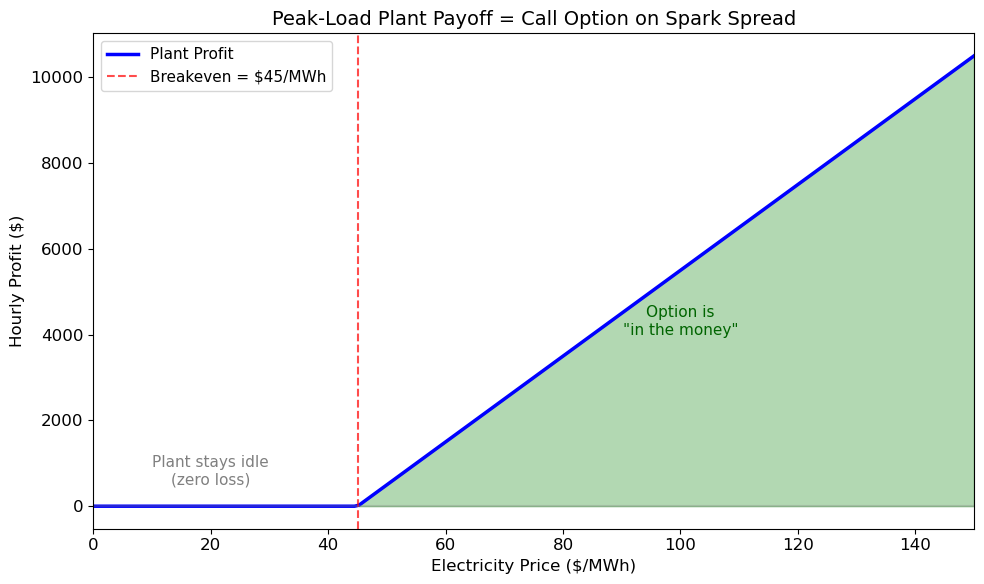

In [15]:
# Fixed gas price, varying electricity price
P_gas_fixed = 5  # $/MMBtu
H = 8            # Heat rate
strike = H * P_gas_fixed + 5  # Effective strike price (including variable cost)

P_elec_range = np.linspace(0, 150, 200)
profits = [float(plant_hourly_profit(p, P_gas_fixed, H)) for p in P_elec_range]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(P_elec_range, profits, 'b-', linewidth=2.5, label='Plant Profit')
ax.axvline(strike, color='r', linestyle='--', alpha=0.7, 
           label=f'Breakeven = ${strike}/MWh')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)

ax.fill_between(P_elec_range, 0, profits, alpha=0.3, color='green',
                where=[p > 0 for p in profits])

ax.set_xlabel('Electricity Price ($/MWh)', fontsize=12)
ax.set_ylabel('Hourly Profit ($)', fontsize=12)
ax.set_title('Peak-Load Plant Payoff = Call Option on Spark Spread', fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(0, 150)

# Annotations
ax.annotate('Option is\n"in the money"', xy=(100, 4000), fontsize=11,
            ha='center', color='darkgreen')
ax.annotate('Plant stays idle\n(zero loss)', xy=(20, 500), fontsize=11,
            ha='center', color='gray')

plt.tight_layout()
plt.show()

## 3. Simulating Electricity Prices

Electricity prices exhibit:
- **High volatility** (much higher than stocks)
- **Mean reversion** (prices snap back)
- **Spikes** (occasional extreme prices)

We use an **Ornstein-Uhlenbeck (OU) process** with jumps:

$$dP = \kappa(\mu - P)dt + \sigma dW + J \cdot dN$$

In [16]:
def simulate_electricity_prices(key, n_hours, P0, mu, kappa, sigma, 
                                 jump_intensity=0.02, jump_mean=50):
    """
    Simulate electricity prices using mean-reverting process with jumps.
    """
    dt = 1/8760  # 1 hour in years
    
    key1, key2, key3 = jax.random.split(key, 3)
    
    # Brownian increments
    dW = jax.random.normal(key1, (n_hours,)) * jnp.sqrt(dt)
    
    # Jump process
    jump_occurs = jax.random.uniform(key2, (n_hours,)) < jump_intensity
    jump_sizes = jax.random.exponential(key3, (n_hours,)) * jump_mean
    jumps = jump_occurs * jump_sizes
    
    # Simulate price path
    prices = [P0]
    P = P0
    for i in range(n_hours):
        dP = kappa * (mu - P) * dt + sigma * dW[i] + jumps[i]
        P = max(P + dP, 0)
        prices.append(P)
    
    return jnp.array(prices)

# Simulate one year of hourly prices
key = jax.random.PRNGKey(42)
n_hours = 8760

# Realistic peak-load scenario: mean price near the strike
elec_prices = simulate_electricity_prices(
    key, n_hours,
    P0=45, mu=45, kappa=200, sigma=15,
    jump_intensity=0.005, jump_mean=100
)

# Strike price for our plant
STRIKE = 48  # Heat rate (10) × Gas price ($4) + Variable cost ($8)

print(f"Price Statistics:")
print(f"  Mean: ${np.mean(elec_prices):.2f}/MWh")
print(f"  Std:  ${np.std(elec_prices):.2f}/MWh")
print(f"  Max:  ${np.max(elec_prices):.2f}/MWh")
print(f"  Strike: ${STRIKE}/MWh")
print(f"  % Hours above strike: {100*np.mean(elec_prices > STRIKE):.1f}%")

Price Statistics:
  Mean: $67.58/MWh
  Std:  $52.05/MWh
  Max:  $731.64/MWh
  Strike: $48/MWh
  % Hours above strike: 53.9%


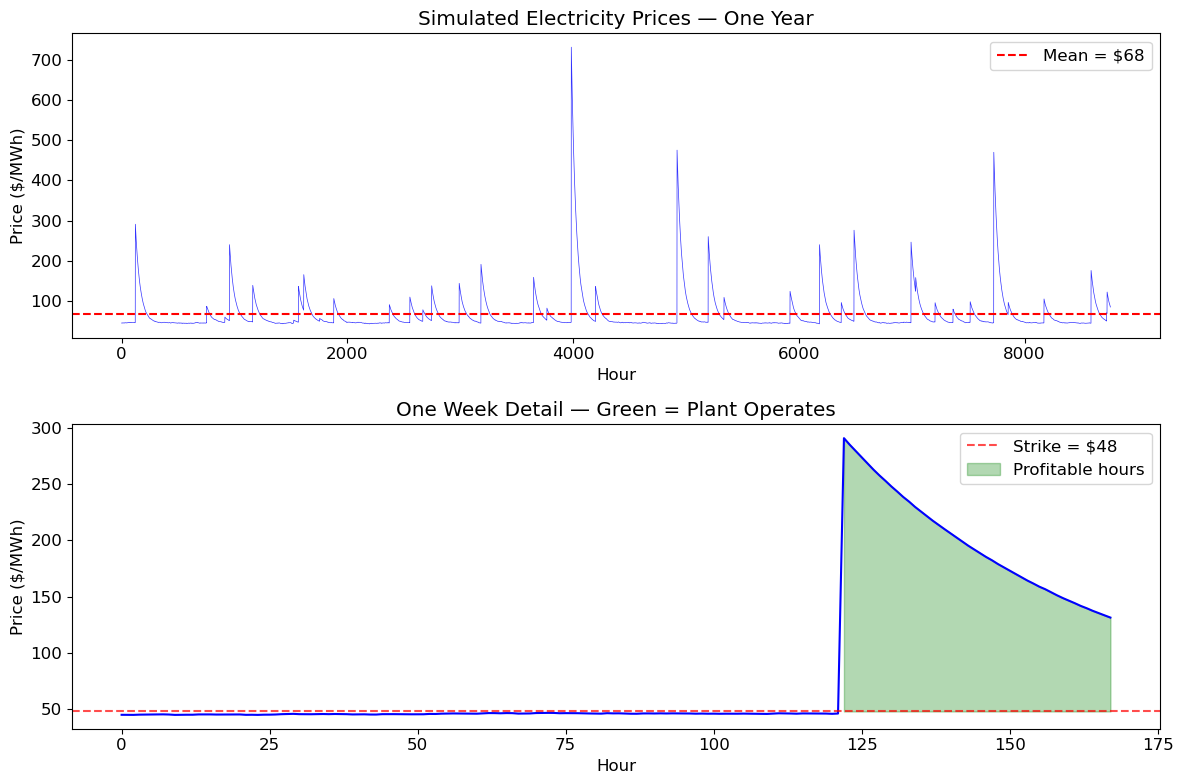

In [17]:
# Plot electricity prices
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Full year
axes[0].plot(elec_prices, 'b-', linewidth=0.5, alpha=0.8)
axes[0].axhline(np.mean(elec_prices), color='r', linestyle='--', 
                label=f'Mean = ${np.mean(elec_prices):.0f}')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Price ($/MWh)')
axes[0].set_title('Simulated Electricity Prices — One Year')
axes[0].legend()

# One week detail
axes[1].plot(elec_prices[:168], 'b-', linewidth=1.5)
axes[1].axhline(STRIKE, color='r', linestyle='--', alpha=0.7, label=f'Strike = ${STRIKE}')
axes[1].fill_between(range(168), STRIKE, elec_prices[:168], 
                     where=elec_prices[:168] > STRIKE,
                     alpha=0.3, color='green', label='Profitable hours')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Price ($/MWh)')
axes[1].set_title('One Week Detail — Green = Plant Operates')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Valuing the Peak-Load Plant

### Static NPV Approach (Wrong)
Assumes the plant runs continuously at average prices.

### Real Options Approach (Correct)
Values the plant as a **strip of hourly call options** on the spark spread.

> **Key Insight:** The value comes from *what you don't do* — staying idle when unprofitable.

In [18]:
def value_plant_monte_carlo(key, n_sims, n_hours, plant_params, price_params):
    """
    Value a peak-load plant using Monte Carlo simulation.
    Compares Static NPV vs Real Options Value.
    """
    capacity = plant_params['capacity_MW']
    heat_rate = plant_params['heat_rate']
    var_cost = plant_params['variable_cost']
    fixed_cost = plant_params['fixed_cost_annual']
    gas_price = plant_params['gas_price']
    
    keys = jax.random.split(key, n_sims)
    
    ro_profits = []
    static_profits = []
    operating_hours = []
    
    for sim_key in keys:
        prices = simulate_electricity_prices(sim_key, n_hours, **price_params)
        
        # Spark spreads for each hour
        spreads = prices[1:] - heat_rate * gas_price
        net_margins = spreads - var_cost
        
        # Real Options: operate only when profitable
        hourly_profits = jnp.maximum(net_margins, 0) * capacity
        annual_ro = float(jnp.sum(hourly_profits)) - fixed_cost
        ro_profits.append(annual_ro)
        
        # Operating hours
        operating_hours.append(float(jnp.sum(net_margins > 0)))
        
        # Static NPV: assume continuous operation at average margin
        avg_margin = float(jnp.mean(spreads)) - var_cost
        annual_static = avg_margin * capacity * n_hours - fixed_cost
        static_profits.append(annual_static)
    
    return {
        'real_options_mean': np.mean(ro_profits),
        'real_options_std': np.std(ro_profits),
        'static_npv_mean': np.mean(static_profits),
        'static_npv_std': np.std(static_profits),
        'option_premium': np.mean(ro_profits) - np.mean(static_profits),
        'avg_operating_hours': np.mean(operating_hours),
        'capacity_factor': np.mean(operating_hours) / n_hours
    }, ro_profits, static_profits

In [19]:
# Plant parameters
plant_params = {
    'capacity_MW': 100,
    'heat_rate': 10,           # Less efficient plant (higher heat rate)
    'variable_cost': 8,        # Higher variable cost
    'fixed_cost_annual': 1_000_000,
    'gas_price': 4,            # Gas price
}
# Strike = 10 × 4 + 8 = $48/MWh

# Price parameters — realistic peak-load scenario
# Mean price NEAR the strike, so plant is sometimes in/out of the money
price_params = {
    'P0': 45, 'mu': 45, 'kappa': 200,  # Fast mean reversion to $45
    'sigma': 15,                        # Moderate volatility
    'jump_intensity': 0.005,            # Rare spikes (0.5% of hours)
    'jump_mean': 100                    # But large when they occur
}

# Run valuation
key = jax.random.PRNGKey(123)
results, ro_profits, static_profits = value_plant_monte_carlo(
    key, n_sims=300, n_hours=8760,
    plant_params=plant_params, price_params=price_params
)

print("="*60)
print("PEAK-LOAD PLANT VALUATION (Annual)")
print("="*60)
print(f"\nStatic NPV: ${results['static_npv_mean']:,.0f} (±${results['static_npv_std']:,.0f})")
print(f"Real Options: ${results['real_options_mean']:,.0f} (±${results['real_options_std']:,.0f})")
print(f"\n{'─'*60}")
print(f"OPTION PREMIUM (Flexibility Value): ${results['option_premium']:,.0f}")
print(f"{'─'*60}")
print(f"\nCapacity Factor: {results['capacity_factor']:.1%}")
print(f"Avg Operating Hours: {results['avg_operating_hours']:,.0f} / 8,760")

PEAK-LOAD PLANT VALUATION (Annual)

Static NPV: $15,522,278 (±$4,328,868)
Real Options: $16,639,809 (±$4,198,296)

────────────────────────────────────────────────────────────
OPTION PREMIUM (Flexibility Value): $1,117,531
────────────────────────────────────────────────────────────

Capacity Factor: 49.2%
Avg Operating Hours: 4,308 / 8,760


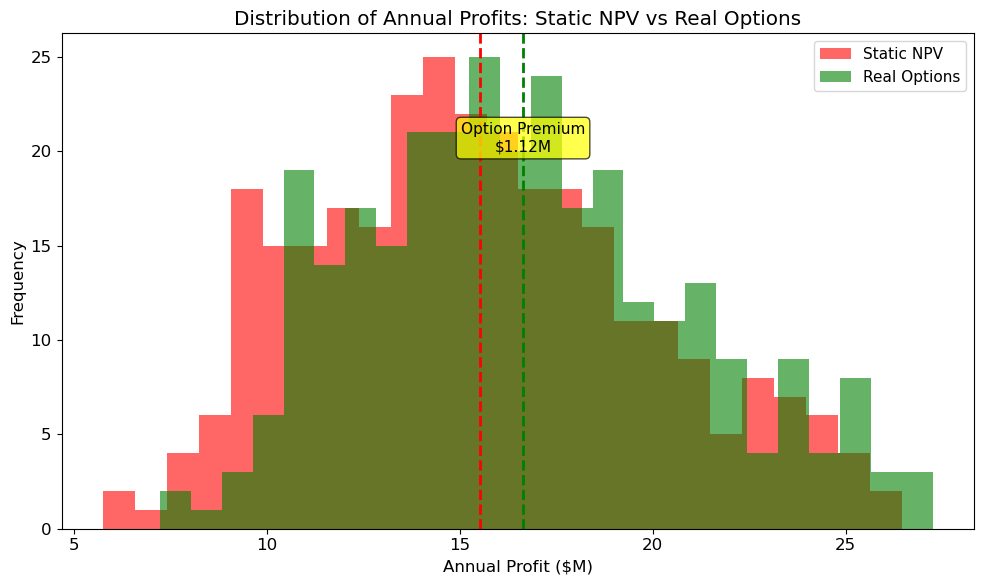

In [20]:
# Visualize profit distributions
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(np.array(static_profits)/1e6, bins=25, alpha=0.6, label='Static NPV', color='red')
ax.hist(np.array(ro_profits)/1e6, bins=25, alpha=0.6, label='Real Options', color='green')
ax.axvline(results['static_npv_mean']/1e6, color='red', linestyle='--', linewidth=2)
ax.axvline(results['real_options_mean']/1e6, color='green', linestyle='--', linewidth=2)

ax.set_xlabel('Annual Profit ($M)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Annual Profits: Static NPV vs Real Options')
ax.legend(fontsize=11)

# Annotate option premium
premium = results['option_premium']/1e6
ax.annotate(f'Option Premium\n${premium:.2f}M', 
            xy=(results['real_options_mean']/1e6, 20),
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 5. Sensitivity Analysis: Volatility and Option Value

A key insight: **Higher volatility increases the value of a peak-load plant.**

This is counterintuitive from a traditional NPV perspective but obvious from option theory:
- Options benefit from volatility (more upside potential)
- Downside is truncated (plant just stays idle)

> **Electricity volatility is an equilibrium signal, not a bug.**

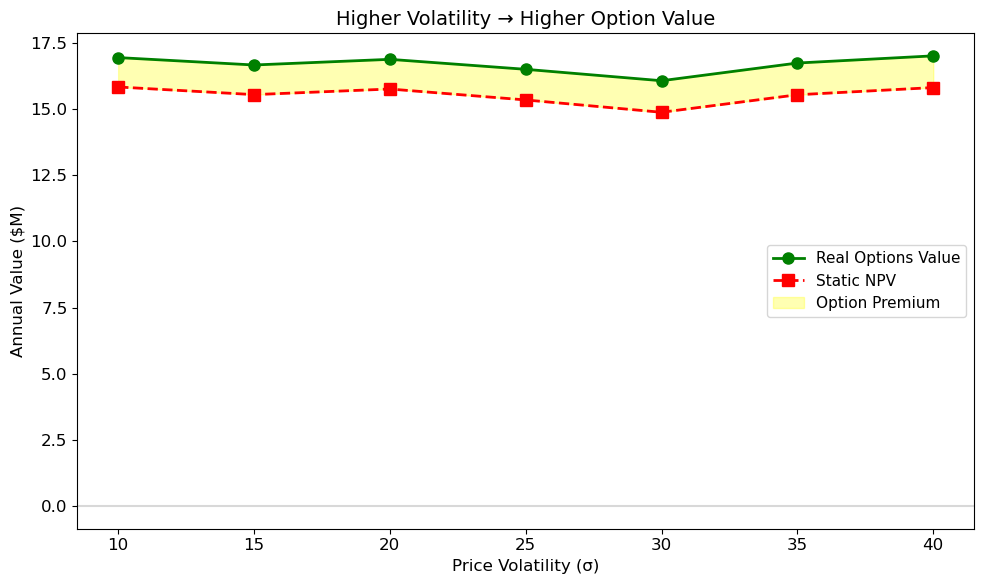


Key Insight:
Real Options Value INCREASES with volatility!
This is why peak-load plants are valuable in volatile markets.


In [21]:
# Sensitivity to volatility
volatilities = [10, 15, 20, 25, 30, 35, 40]
ro_values = []
static_values = []

key = jax.random.PRNGKey(789)

for vol in volatilities:
    key, subkey = jax.random.split(key)
    price_params_temp = price_params.copy()
    price_params_temp['sigma'] = vol
    
    res, _, _ = value_plant_monte_carlo(
        subkey, n_sims=100, n_hours=8760,
        plant_params=plant_params, price_params=price_params_temp
    )
    ro_values.append(res['real_options_mean'])
    static_values.append(res['static_npv_mean'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(volatilities, np.array(ro_values)/1e6, 'g-o', linewidth=2, 
        markersize=8, label='Real Options Value')
ax.plot(volatilities, np.array(static_values)/1e6, 'r--s', linewidth=2, 
        markersize=8, label='Static NPV')

ax.fill_between(volatilities, 
                np.array(static_values)/1e6, 
                np.array(ro_values)/1e6,
                alpha=0.3, color='yellow', label='Option Premium')

ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Price Volatility (σ)', fontsize=12)
ax.set_ylabel('Annual Value ($M)', fontsize=12)
ax.set_title('Higher Volatility → Higher Option Value', fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("Real Options Value INCREASES with volatility!")
print("This is why peak-load plants are valuable in volatile markets.")

## 6. Summary: The Real Options Perspective

### What We Learned

1. **A peak-load plant is a portfolio of call options** on the spark spread
   - Each hour = one option
   - Strike = Heat Rate × Gas Price + Variable Cost

2. **Static NPV undervalues flexibility**
   - Assumes continuous operation
   - Ignores the value of "doing nothing"

3. **Volatility is your friend** (if you have options)
   - Higher volatility → Higher option value
   - Downside is truncated by operational flexibility

4. **Real Options = NPV done correctly**
   - When managers have discretion, use option pricing
   - Value comes from future decisions, not just cash flows

### The DP Connection

This is **dynamic programming** in action:
- At each time step, we make the optimal decision (operate or idle)
- The value function depends on the state (current prices)
- We work backward from the terminal condition

The LSMC notebook (Chapter 10) showed this explicitly for American options.

In [22]:
# Key Takeaways Table
print("="*60)
print("CHAPTER 17 KEY TAKEAWAYS")
print("="*60)

takeaways = [
    ("Peak-load plant", "= Strip of call options on spark spread"),
    ("Spark spread", "= P_elec - H × P_gas"),
    ("Shutdown flexibility", "= Put option"),
    ("Higher volatility", "= Higher option value"),
    ("Static NPV", "= Ignores flexibility (wrong!)"),
    ("Real Options NPV", "= Values optimal decisions"),
]

for concept, meaning in takeaways:
    print(f"  {concept:25} {meaning}")

CHAPTER 17 KEY TAKEAWAYS
  Peak-load plant           = Strip of call options on spark spread
  Spark spread              = P_elec - H × P_gas
  Shutdown flexibility      = Put option
  Higher volatility         = Higher option value
  Static NPV                = Ignores flexibility (wrong!)
  Real Options NPV          = Values optimal decisions
